In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models import AlexNet, alexnet, resnet18, resnet50
import torch.nn.functional as nF
import torchvision.transforms.functional as tF
from torch.optim.optimizer import Optimizer
import torchvision
import albumentations as albu
import cv2

/opt/anaconda3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/anaconda3/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: <9E417059-FF86-3C93-B8D5-8A071C12B008> /opt/anaconda3/lib/python3.8/site-packages/torchvision/image.so
  Expected in:     <A062B672-5D82-382B-9F21-CADC8B6302DD> /opt/anaconda3/lib/python3.8/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")


In [2]:
!ls

Alexnet_weight.pth    csv_emotion6          sample_submission.csv
Emotion6              emotion.ipynb         submit.csv


In [3]:
!ls ./Emotion6/

anger    disgust  fear     joy      sadness  surprise


In [4]:
!ls ./csv_emotion6

ground_truth_test.csv  ground_truth_train.csv
ground_truth_test.txt  ground_truth_train.txt


In [5]:
train = pd.read_csv('./csv_emotion6/ground_truth_train.csv')
test = pd.read_csv('./csv_emotion6/ground_truth_test.csv')

In [6]:
train.head()

,image,label
0,disgust/1.jpg,2
1,surprise/1.jpg,4
2,fear/1.jpg,3
3,joy/1.jpg,4
4,sadness/1.jpg,5


In [7]:
test.head()

,image
0,anger/230.jpg
1,disgust/245.jpg
2,disgust/249.jpg
3,joy/253.jpg
4,disgust/255.jpg


In [8]:
train["label"] = train["label"]-1

In [28]:
class Dataset(Dataset):
    def __init__(self, df, phase, transform=None):
        self.df = df
        self.phase = phase
        self.transform = transform
        self.emotion_path = "./Emotion6"
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img = self.pull_item(index)
        img = self.transform(img)
        if self.phase=="train":
            return img, self.df["label"].iloc[index]
        elif self.phase=="test":
            return img
        
    def pull_item(self, index):
        img_path = os.path.join(self.emotion_path, self.df["image"].iloc[index])
        img = cv2.imread(img_path)
        return img

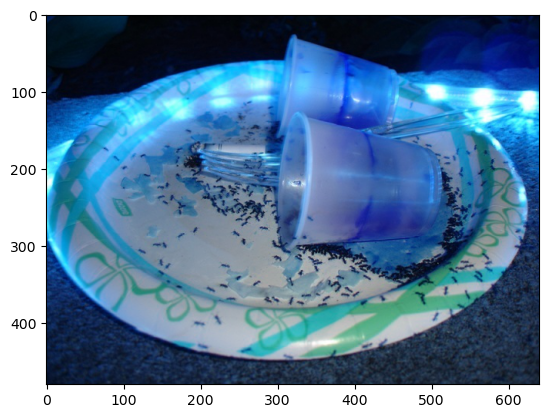

In [10]:
plt.imshow(cv2.imread((os.path.join("./Emotion6", train["image"].iloc[0]))))

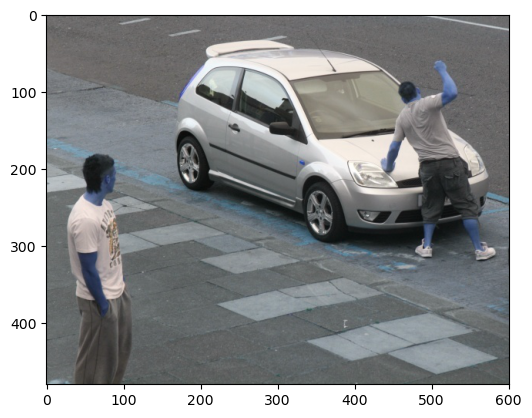

In [11]:
path = "./Emotion6/anger/230.jpg"
plt.imshow(cv2.imread(path))

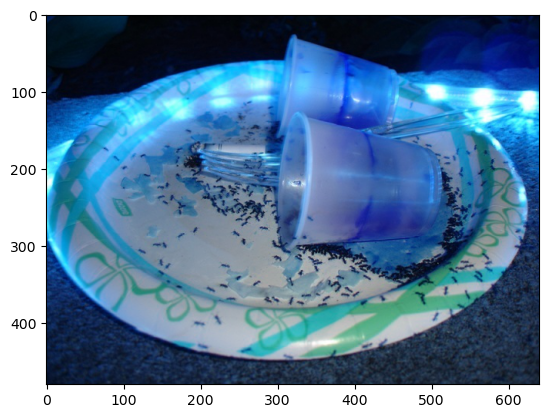

In [12]:
path = "./Emotion6/disgust/1.jpg"
plt.imshow(cv2.imread(path))

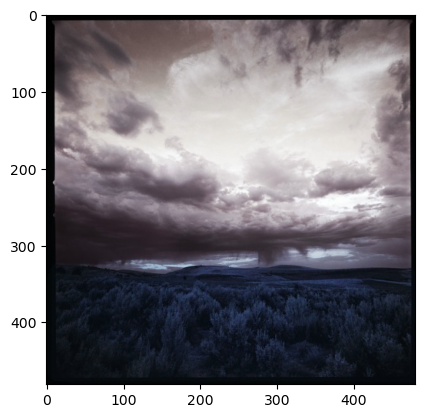

In [13]:
path = "./Emotion6/surprise/1.jpg"
plt.imshow(cv2.imread(path))

In [14]:
train["image"][0]

'disgust/1.jpg'

In [15]:
print(len(train), len(test))

1587 393


In [16]:
print(len(train[:1200]), len(train[1200:]))

1200 387


In [29]:
batch_size=200
# データ拡張
train_transformer = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.RandomResizedCrop(224),
                            transforms.RandomHorizontalFlip(),
                            transforms.RandomVerticalFlip(),
                            transforms.RandomGrayscale(),
                            transforms.RandomRotation(10),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ])
test_transformer = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Resize((224, 224)),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                            ])
train_dataset = Dataset(train[:1200], "train", transform=train_transformer)
val_dataset = Dataset(train[1200:], "train", transform=test_transformer)
test_dataset = Dataset(test, "test", transform=test_transformer)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader =DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [18]:
"""
for imgs, labels in train_dataloader:
    for img in imgs:
        print(img.shape)
"""

'\nfor imgs, labels in train_dataloader:\n    for img in imgs:\n        print(img.shape)\n'

In [19]:
# モデル定義
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
#model = AlexNet()

In [21]:
#model = alexnet(pretrained=False, num_classes=7)
model = resnet18(pretrained=False, num_classes=7)

/opt/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [22]:
# 損失関数
criterion = nn.CrossEntropyLoss()

# 最適化手法
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
#optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

In [23]:
train_acc_list, val_loss_list, val_acc_list = [], [], []
num_epoch=20
for epoch in range(num_epoch):
    train_loss, train_acc, val_loss, val_acc = 0, 0, 0, 0
    model.train()
    for imgs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        train_acc += (outputs.max(1)[1] == labels).sum().item()
        loss.backward()
        optimizer.step()
    avg_train_loss = train_loss / len(train_dataloader.dataset)
    avg_train_acc = train_acc / len(train_dataloader.dataset)
    
    # ====== val_mode ======
    model.eval()
    with torch.no_grad():
        for imgs, labels in val_dataloader:
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_val_loss = val_loss / len(val_dataloader.dataset)
    avg_val_acc = val_acc / len(val_dataloader.dataset)
    
    print("epoch:{}".format(epoch))
    print("avg_train_loss:{}　avg_train_acc:{}".format(avg_train_loss, avg_train_acc)) #0.355 0.3091
    print("avg_val_loss:{} avg_val_acc:{}".format(avg_val_loss, avg_val_acc))

epoch:0
avg_train_loss:0.009492599070072175　avg_train_acc:0.2375
avg_val_loss:0.00935779431069544 avg_val_acc:0.16795865633074936
epoch:1
avg_train_loss:0.008971518476804097　avg_train_acc:0.2991666666666667
avg_val_loss:0.009291640547818916 avg_val_acc:0.17054263565891473
epoch:2
avg_train_loss:0.009047213395436605　avg_train_acc:0.2833333333333333
avg_val_loss:0.008796516006923154 avg_val_acc:0.3333333333333333
epoch:3
avg_train_loss:0.00867001454035441　avg_train_acc:0.2925
avg_val_loss:0.008870727024029084 avg_val_acc:0.3385012919896641
epoch:4
avg_train_loss:0.008403875430425008　avg_train_acc:0.3358333333333333
avg_val_loss:0.008772833094732398 avg_val_acc:0.3462532299741602
epoch:5
avg_train_loss:0.008194092611471812　avg_train_acc:0.3458333333333333
avg_val_loss:0.008621006356961352 avg_val_acc:0.35400516795865633
epoch:6
avg_train_loss:0.00838109572728475　avg_train_acc:0.32416666666666666
avg_val_loss:0.00899284970236687 avg_val_acc:0.29198966408268734
epoch:7
avg_train_loss:0.0084

In [25]:
outputs[0]

tensor([-3.2970,  2.6158, -0.4732, -0.1474,  0.0215, -0.7913,  0.9169])

In [26]:
torch.save(model.state_dict(), 'resnet18_weight.pth')

In [ ]:
model = AlexNet()
model.load_state_dict(torch.load('Alexnet_weight.pth'))

In [43]:
model.eval()
predicts = []
with torch.no_grad():
    for img in test_dataloader:
        predict = model(img)
        predicts.append(predict.argmax())

In [46]:
sample_submission = pd.read_csv('./sample_submission.csv')
#sample_submission["label"] = predicts
sample_submission['label'] = pd.Series(predicts, dtype='int')

In [53]:
sample_submission = sample_submission[['image', 'label']]

In [55]:
sample_submission.to_csv('./submit2.csv', index=False)